In [1]:
# This notebook, 'kernels' folder, nrkmeans.py and PreDeCon.py have to be in tudataset/tud_benchmark/ directory

# This means that you have to first download the TUDataset Repository e.g. with
# git clone https://github.com/chrsmrrs/tudataset.git

# Data Mining 20W group programming assignment

### Group 1
### dataset - IMDB_Binary
### algorithm - PreDeCon

In [2]:
import os
import numpy as np
from sklearn.datasets import make_blobs
from PreDeCon import PreDeCon
from nrkmeans import NrKmeans
from auxiliarymethods import datasets as dp
from auxiliarymethods.reader import tud_to_networkx
import pandas as pd
from sklearn.decomposition import KernelPCA, TruncatedSVD
from matplotlib import pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score
import seaborn as sns
from scipy.sparse import load_npz
import auxiliarymethods.auxiliary_methods as aux
import networkx as nx
from sklearn.cluster import KMeans
from copy import deepcopy

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


# Exploratory Data Analysis

Gram matrices and sparse vectors are in the directory:

> kernels/without_labels

The generated Gram matrices and sparse vectors *kernels/without_labels* use no node labels and are completely relying on the topology. 

IMBD-Binary data set only has a representation without using the node labels.

In [9]:
# utility functions
def load_csv(path):
    return np.loadtxt(path, delimiter=";")

def load_sparse(path):
    return load_npz(path)

def select_from_list(l, indices):
    return [l[i] for i in indices]

## Example usage for gram matrix and sparse matrix with Weisfeiler-Lehman kernel

Load from  kernels/without_labels
##################################
Dataset  IMDB-BINARY
Iteration  1
##################################
(1000, 1000) (1000, 4009)
n_clusters:  2
TSVD


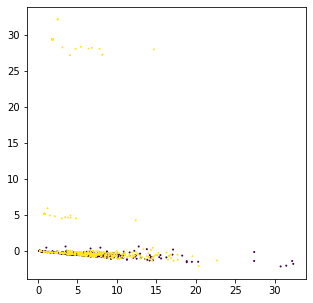

Found Cluster Subspaces:  [1, 99]
Subkmeans NMI:0.0483


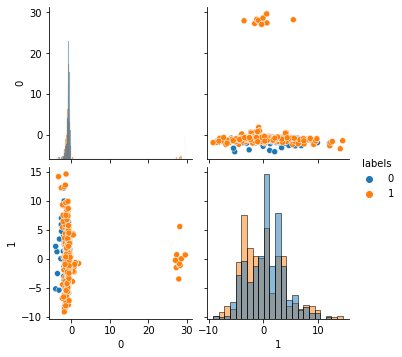

KPCA


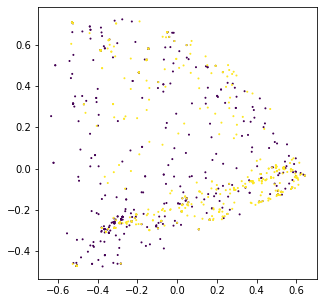

Found Cluster Subspaces:  [1, 99]
Subkmeans NMI:0.0577


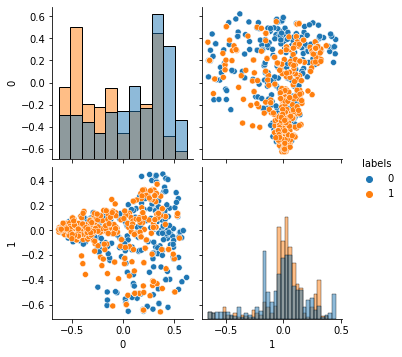

Spectral  NMI:0.0574
PreDeCon  NMI:0.0000
##################################
##################################
Dataset  IMDB-BINARY
Iteration  2
##################################
(1000, 1000) (1000, 8853)
n_clusters:  2
TSVD


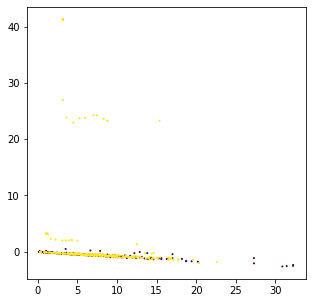

Found Cluster Subspaces:  [1, 99]
Subkmeans NMI:0.0483


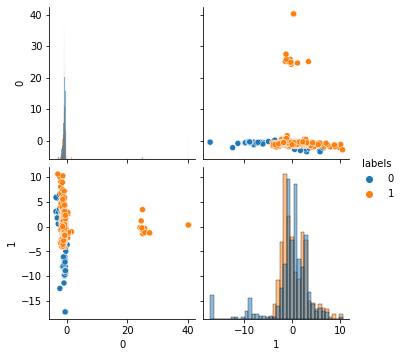

KPCA


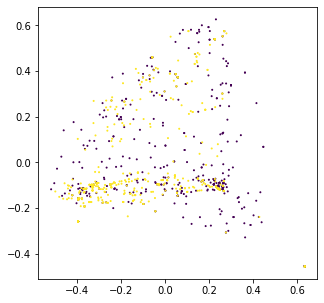

Found Cluster Subspaces:  [1, 99]
Subkmeans NMI:0.0569


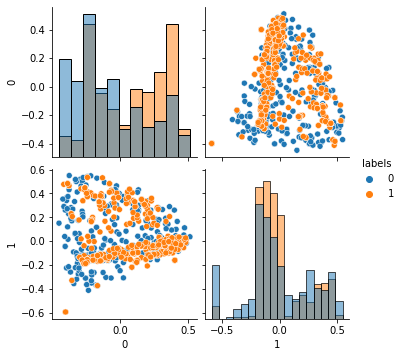

Spectral  NMI:0.0544
PreDeCon  NMI:0.0000
##################################
##################################
Dataset  IMDB-BINARY
Iteration  3
##################################
(1000, 1000) (1000, 13717)
n_clusters:  2
TSVD


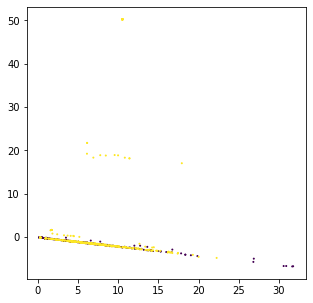

Found Cluster Subspaces:  [1, 99]
Subkmeans NMI:0.0289


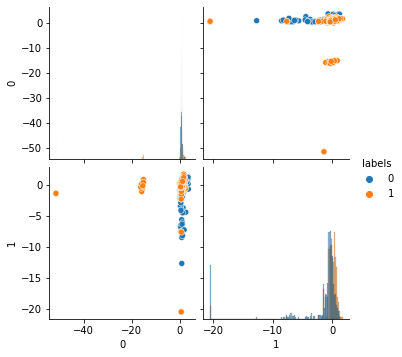

KPCA


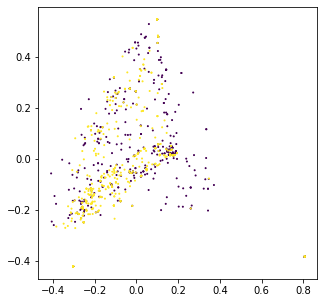

Found Cluster Subspaces:  [1, 99]
Subkmeans NMI:0.0406


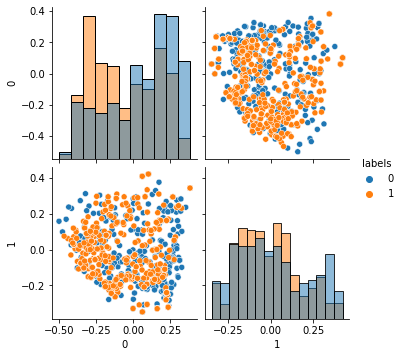

Spectral  NMI:0.0323
PreDeCon  NMI:0.0000
##################################
##################################
Dataset  IMDB-BINARY
Iteration  4
##################################
(1000, 1000) (1000, 18581)
n_clusters:  2
TSVD


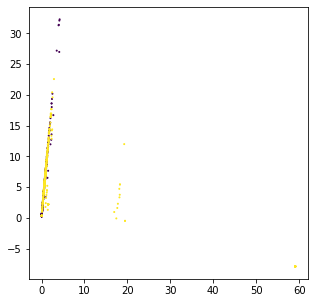

Found Cluster Subspaces:  [1, 99]
Subkmeans NMI:0.0289


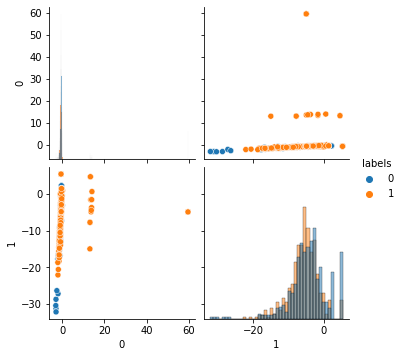

KPCA


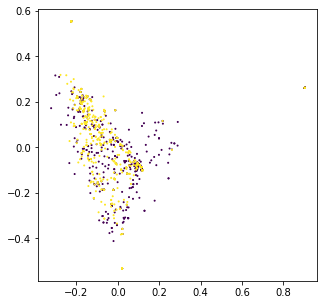

Found Cluster Subspaces:  [1, 99]
Subkmeans NMI:0.0239


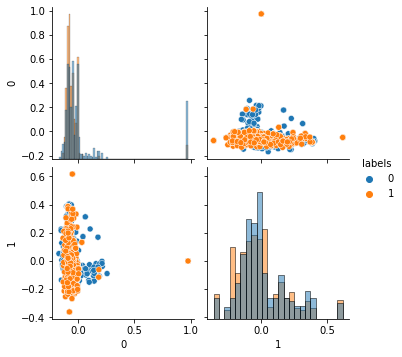

Spectral  NMI:0.0544
PreDeCon  NMI:0.0000
##################################
##################################
Dataset  IMDB-BINARY
Iteration  5
##################################
(1000, 1000) (1000, 23445)
n_clusters:  2
TSVD


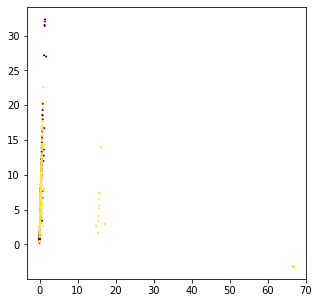

Found Cluster Subspaces:  [1, 99]
Subkmeans NMI:0.0289


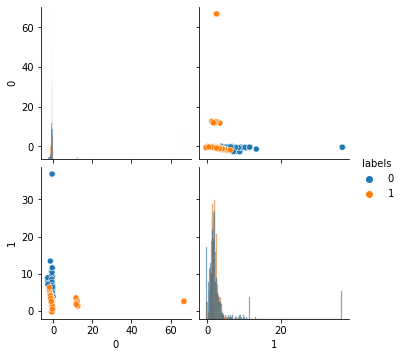

KPCA


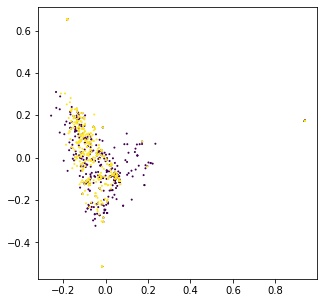

Found Cluster Subspaces:  [1, 99]
Subkmeans NMI:0.0459


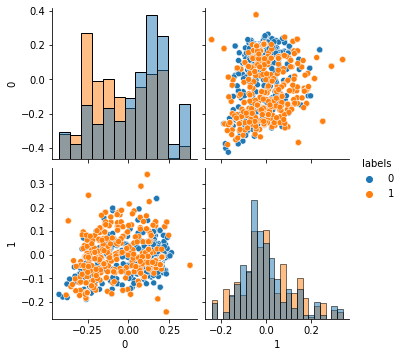

Spectral  NMI:0.0323
PreDeCon  NMI:0.0000
##################################


In [10]:
# # This code was used to get the results for each data set above:
# # Get some initial results for each data set
# # This will plot all representations and cluster these with Spectral Clustering and Subkmeans
# # In your case you might only want to run your data set

use_edge_labels = False
base_path = os.path.join("kernels", "without_labels")
dataset = "IMDB-BINARY"
print("Load from ", base_path)
nmis_kpca = {}
nmis_tsvd = {}
nmis_spec = {}
nmis_pred = {}

classes = dp.get_dataset(dataset)
nmis_kpca[dataset] = []
nmis_tsvd[dataset] = []
nmis_spec[dataset] = []
nmis_pred[dataset] = []

for iterations in range(1,6):
    # 0 taking just the nodelabels themselves into account; 
     # 1 considers nearest-neighbours, 2 one layer deeper and so on
    # play with this parameter to create a new kernel!
    print("##################################")
    print("Dataset ", dataset)
    print("Iteration ", iterations)
    print("##################################")

    #Gram Matrix for the Weisfeiler-Lehman subtree kernel
    gram = load_csv(os.path.join(base_path,f"{dataset}_gram_matrix_wl{iterations}.csv"))
    gram = aux.normalize_gram_matrix(gram)

    #Sparse Vectors for the Weisfeiler-Lehmann subtree kernel
    vec = load_sparse(os.path.join(base_path,f"{dataset}_vectors_wl{iterations}.npz"))
    print(gram.shape, vec.shape)

    tsvd = TruncatedSVD(n_components=100)
    reduced_tsvd = tsvd.fit_transform(vec)

    kpca = KernelPCA(n_components=100, kernel="precomputed")
    reduced_kpca = kpca.fit_transform(gram)

    k = len(set(classes.tolist()))
    print("n_clusters: ", k)
    d = {0:"TSVD",1:"KPCA"}
    n_d = {0:nmis_tsvd, 1:nmis_kpca}
    for i,rep_i in enumerate([reduced_tsvd, reduced_kpca]):
        print(d[i])

        fig, ax = plt.subplots(figsize=(5,5))
        ax.scatter(rep_i[:,0], rep_i[:,1], c=classes, s=1)
        plt.show();

        # Apply Subkmeans
        nrkm = NrKmeans(n_clusters=[k,1])#, allow_larger_noise_space=False)
        nrkm.fit(rep_i, best_of_n_rounds=10, verbose=False)
        print("Found Cluster Subspaces: ", nrkm.m)
        subkm_nmi = normalized_mutual_info_score(nrkm.labels[0],classes)
        print(f"Subkmeans NMI:{subkm_nmi:.4f}")
        n_d[i][dataset].append(subkm_nmi)
        # Plot rotated space
        V = nrkm.V
        rotated = np.dot(rep_i,V)
        reduced_df = pd.DataFrame(rotated[:,0:2])             
        reduced_df["labels"] = classes#nrkm.labels[0]
        sns.pairplot(reduced_df, hue="labels", diag_kind="hist")
        plt.show();

    # Apply Spectral Clustering
    spec = SpectralClustering(n_clusters=k, affinity="precomputed")
    spec.fit(gram)
    spec_nmi = normalized_mutual_info_score(spec.labels_,classes)
    nmis_spec[dataset].append(spec_nmi)
    print(f"Spectral  NMI:{spec_nmi:.4f}")   

    # Apply PreDeCon
    epsilon=1; delta=0.25; mu=10; lamb=1; kappa=50 # set parameters
    pred = PreDeCon(data=gram, epsilon=epsilon, delta=delta, mu=mu, lamb=lamb, kappa=kappa)
    pred.fit()
    pred_nmi = normalized_mutual_info_score(pred.labels_, classes)
    nmis_pred[dataset].append(pred_nmi)
    print(f"PreDeCon  NMI:{pred_nmi:.4f}")   

    print("##################################")

res = {"KPCA":nmis_kpca,"TSVD": nmis_tsvd, "SPEC": nmis_spec, "PRED": nmis_pred}
for key, value in res.items():
    nmi_df = pd.DataFrame(res[key])
    nmi_df.to_csv(os.path.join(base_path, key + ".csv"))

## Overview of NMI performance for different representations

### KPCA
Applied [Kernel PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html) with the provided Gram matrix and then clustered the reduced representation with Subkmeans with $k=$'number of ground truth classes'.


### SVD
Applied [Truncated SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) a version of SVD that can handle sparse feature matrices and then clustered the reduced representation with Subkmeans with $k=$'number of ground truth classes'.

### Spectral Clustering
Applied [Spectral Clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html), an algorithm that is often used to cluster graph data, with the similarities provided by the Gram matrices and with $k=$'number of ground truth classes'. In contrast to Subkmeans Spectral Clustering can find arbitrarily shaped clusters.

#################without_labels#################
path_i kernels/KPCA.csv


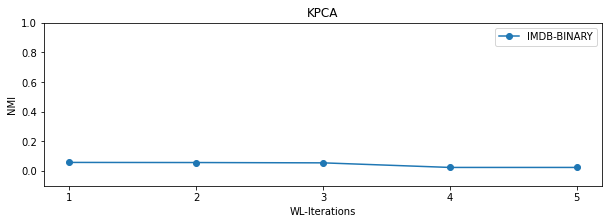

path_i kernels/TSVD.csv


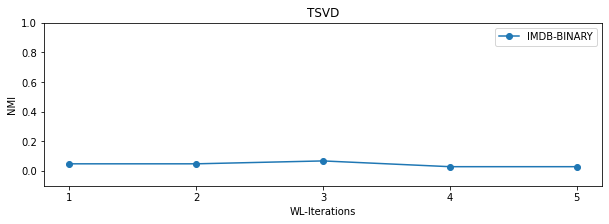

path_i kernels/SPEC.csv


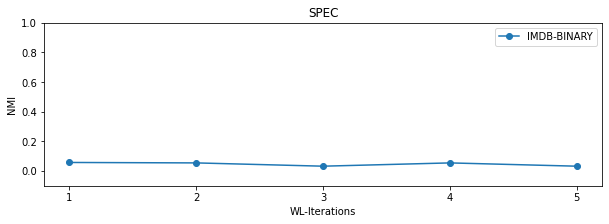

path_i kernels/PRED.csv


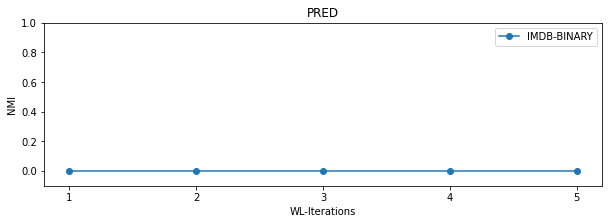

In [11]:
result_names = ["KPCA", "TSVD", "SPEC", "PRED"]
version = "without_labels"
print(f"#################{version}#################")
for name_i in result_names:
    path_i = os.path.join("kernels", name_i+".csv")
    print("path_i", path_i)
    nmi_df = pd.read_csv(path_i, index_col=0)
    fig, ax = plt.subplots(figsize=(10,3))
    ax.set_ylabel("NMI")
    ax.set_xlabel("WL-Iterations")
    ax.set_ylim([-0.1,1])
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels([1,2,3,4,5])
    ax.set_title(name_i)
    nmi_df.plot(marker="o", ax=ax)
    plt.show();

## Visualize and interpret your results

IMDB-BINARY data set.

In [12]:
def visualize(G, color=None, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, 
                     pos=nx.spring_layout(G, seed=42),
                     with_labels=True,
                     node_color=color,
                     cmap="Set2")
    plt.show();

In [13]:
base_path = os.path.join("kernels", "without_labels")
ds_name = "IMDB-BINARY"
classes = dp.get_dataset(ds_name)
G = tud_to_networkx(ds_name)
print(f"Number of graphs in data set is {len(G)}")
print(f"Number of classes {len(set(classes.tolist()))}")

Number of graphs in data set is 1000
Number of classes 2


## Let's start by plotting a single graph of our data set

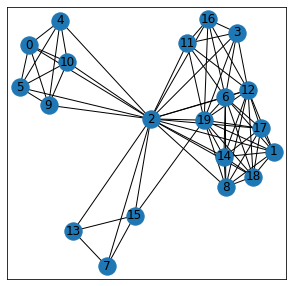

In [14]:
# We just use the first in the list
idx = 0
visualize(G[idx])

## Plot the vector representation with KernelPCA

Just by this plot we can already see that there are outliers that might disturb our K-Means assumptions

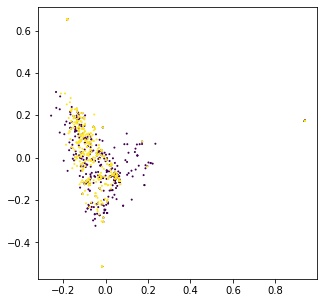

In [15]:
#Gram Matrix for the Weisfeiler-Lehman subtree kernel
iterations = 5
gram = load_csv(os.path.join(base_path,f"{ds_name}_gram_matrix_wl{iterations}.csv"))
gram = aux.normalize_gram_matrix(gram)

kpca = KernelPCA(n_components=100, kernel="precomputed")
reduced_kpca = kpca.fit_transform(gram)
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(reduced_kpca[:,0], reduced_kpca[:,1], c=classes, s=1)
plt.show();

## Plot the vector representation with TruncatedSVD

Also here we can see some outlier points. 

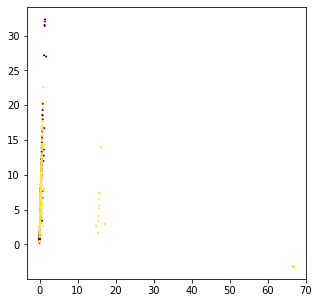

In [16]:
#Gram Matrix for the Weisfeiler-Lehman subtree kernel
iterations = 5
vec = load_sparse(os.path.join(base_path,f"{ds_name}_vectors_wl{iterations}.npz"))
tsvd = TruncatedSVD(n_components=100)
reduced_tsvd = tsvd.fit_transform(vec)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(reduced_tsvd[:,0], reduced_tsvd[:,1], c=classes, s=1)
plt.show();

## Apply Subkmeans with KernelPCA

As expected from the results above the Subkmeans model might not be well suited to find the ground truth clusters of the IMDB-BINARY data set.

In [17]:
k = len(set(classes.tolist()))
print("n_clusters: ", k)
nrkm = NrKmeans(n_clusters=[k,1], allow_larger_noise_space=True)
nrkm.fit(reduced_kpca, best_of_n_rounds=10, verbose=False)
print("Found Cluster Subspaces: ", nrkm.m)
subkm_nmi = normalized_mutual_info_score(nrkm.labels[0],classes)
print(f"Subkmeans NMI:{subkm_nmi:.4f}")    

n_clusters:  2
Found Cluster Subspaces:  [1, 99]
Subkmeans NMI:0.0239


**Plot the rotated space**

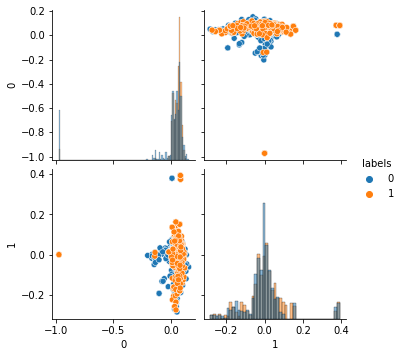

In [18]:
V = nrkm.V
rotated = np.dot(reduced_kpca,V)
reduced_df = pd.DataFrame(rotated[:,0:2])
reduced_df["labels"] = classes
sns.pairplot(reduced_df, hue="labels", diag_kind="hist")
plt.show();

## Cluster Analysis with KMeans

But, we can still use clustering to further explore the data set.
Here we use a simple technique for interpreting our cluster results for the IMBD-BINARY data set.
We investigate the nearest neighbours of each centroid in each cluster.

In [19]:
# only keep the first 10 components to speed up computation
reduced_kpca_10 = reduced_kpca[:, 0:10]

### First we determine the number of k clusters using a scree plot

In [20]:
costs = []
kmeans_runs = []
k_list = [1, 2, 5, 10, 15, 20, 25, 30, 35, 40]
for k in k_list:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(reduced_kpca_10)
    costs.append(kmeans.inertia_)
    kmeans_runs.append(deepcopy(kmeans))

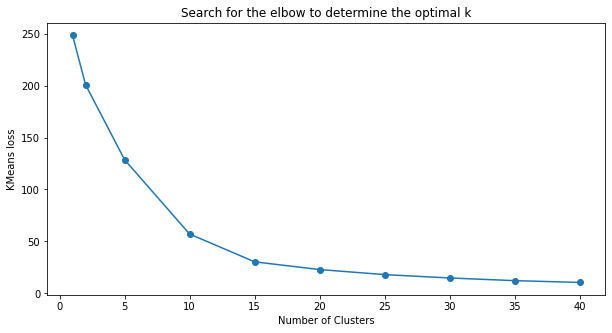

In [21]:
def scree_plot(k_list, costs):
    plt.figure(figsize=(10,5))
    plt.plot(k_list, costs, marker="o")
    plt.xlabel('Number of Clusters')
    plt.ylabel('KMeans loss')
    plt.title('Search for the elbow to determine the optimal k')
    plt.show();
scree_plot(k_list, costs)

Choose k=10

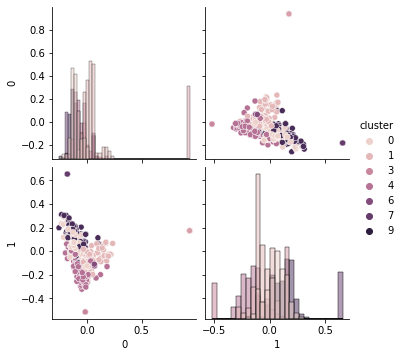

In [22]:
selected_idx = 3
kmeans = kmeans_runs[selected_idx]
df = pd.DataFrame(reduced_kpca_10[:,0:2])
df["cluster"] = kmeans.labels_
sns.pairplot(df, hue="cluster", diag_kind="hist")
# sns.pairplot(df, hue="cluster", diag_kind="hist", height=4)
plt.show();

## Plot the first n nearest neighbours of each centroid

In [23]:
from sklearn.metrics import pairwise_distances
# select first 2 nearest neighbours in for each cluster
nr_nearest = 2
nearest_indices = []
for cluster_i in set(kmeans.labels_):
    mask = (kmeans.labels_ == cluster_i)
    selection = reduced_kpca_10[mask]
    print(f"number of data points in cluster {cluster_i}: {selection.shape[0]}")
    center_i = kmeans.cluster_centers_[cluster_i].reshape(1,-1)
    distances_i = pairwise_distances(center_i, reduced_kpca_10)
    nearest_indices.append(np.argsort(distances_i, )[0][0:nr_nearest])
    print(f"Nearest data points in cluster {cluster_i}: {nearest_indices[-1]}")


number of data points in cluster 0: 204
Nearest data points in cluster 0: [713 547]
number of data points in cluster 1: 278
Nearest data points in cluster 1: [367 114]
number of data points in cluster 2: 48
Nearest data points in cluster 2: [190 192]
number of data points in cluster 3: 24
Nearest data points in cluster 3: [980 721]
number of data points in cluster 4: 182
Nearest data points in cluster 4: [982 735]
number of data points in cluster 5: 17
Nearest data points in cluster 5: [517 563]
number of data points in cluster 6: 16
Nearest data points in cluster 6: [630 824]
number of data points in cluster 7: 31
Nearest data points in cluster 7: [609  95]
number of data points in cluster 8: 185
Nearest data points in cluster 8: [959 523]
number of data points in cluster 9: 15
Nearest data points in cluster 9: [166 121]


Cluster 0, Indices [713 547]


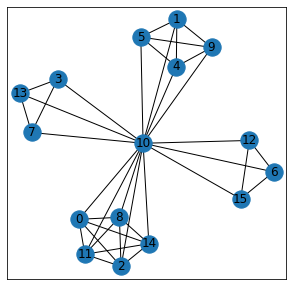

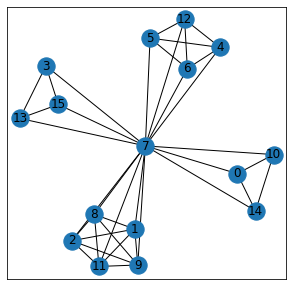

Cluster 1, Indices [367 114]


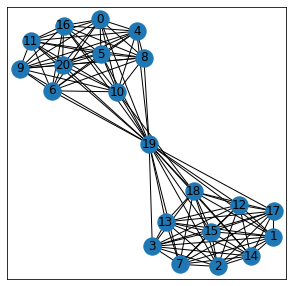

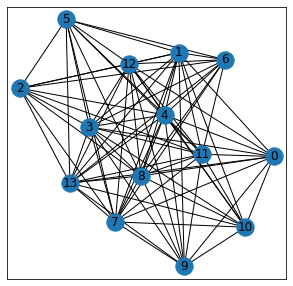

Cluster 2, Indices [190 192]


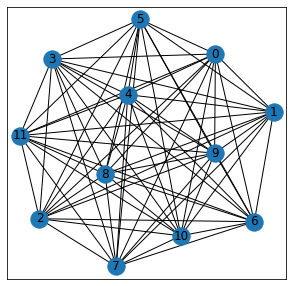

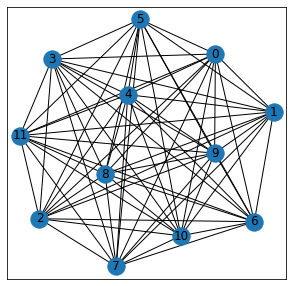

Cluster 3, Indices [980 721]


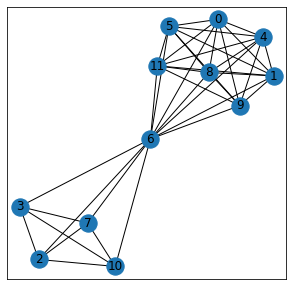

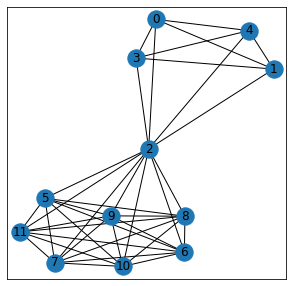

Cluster 4, Indices [982 735]


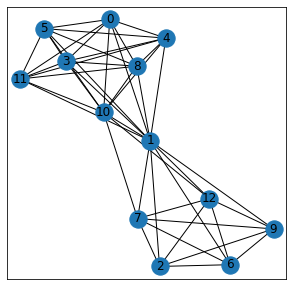

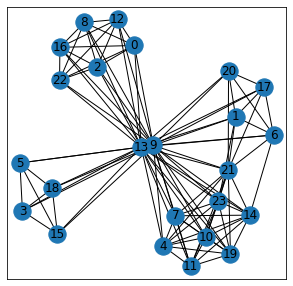

Cluster 5, Indices [517 563]


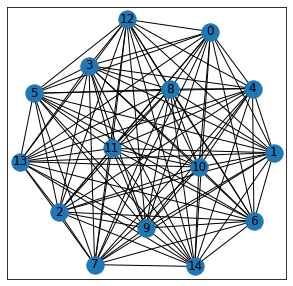

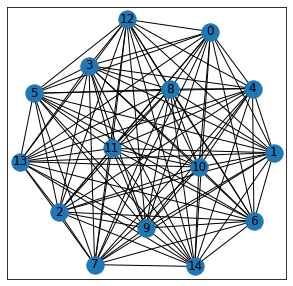

Cluster 6, Indices [630 824]


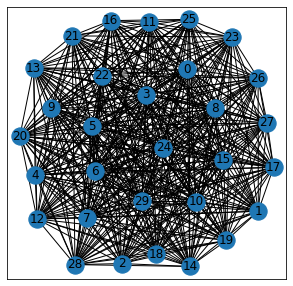

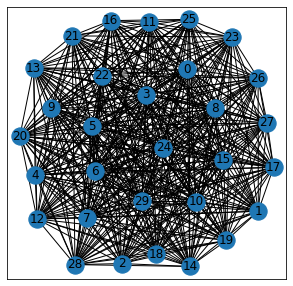

Cluster 7, Indices [609  95]


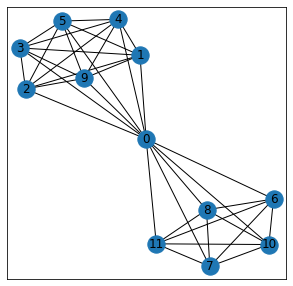

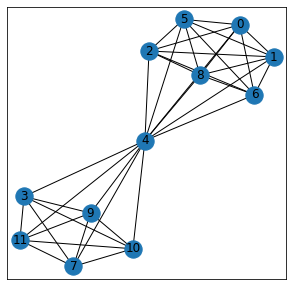

Cluster 8, Indices [959 523]


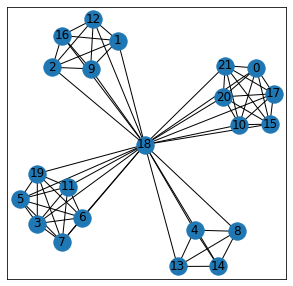

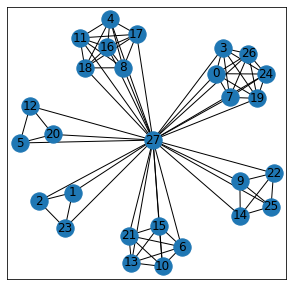

Cluster 9, Indices [166 121]


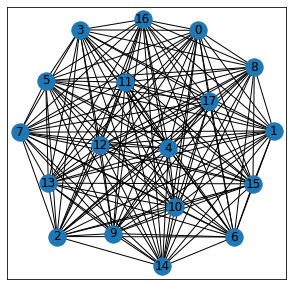

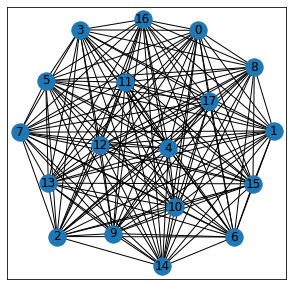

In [24]:
for i, indices in enumerate(nearest_indices):
    print(f"Cluster {i}, Indices {indices}")
    G_selected = select_from_list(G, indices)
    for g_i in G_selected:
        visualize(g_i)